In [5]:
"""
ContraEEND - Phase 3: Adaptive Chunk-wise EEND with Memory
Memory-augmented processing for long-form conversations
"""
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import Tuple, Dict, List, Optional
import random
from tqdm import tqdm
import math
from itertools import permutations
from scipy.optimize import linear_sum_assignment
import torch.nn.functional as F
from torch.utils.data import BatchSampler
from datetime import datetime
import csv
# ============================================================================
# REUSE FROM PHASE 1 & 2
# ============================================================================

def set_seed(seed=42):
    """Set random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def setup_device():
    """Setup device with comprehensive CUDA checking"""
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print(f"✅ CUDA is available!")
        print(f"🚀 Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        torch.cuda.empty_cache()
    else:
        device = torch.device("cpu")
        print("⚠️  CUDA not available, using CPU")
    return device

setup_device()

class AudioProcessor:
    """Unified audio processing pipeline"""
    def __init__(self, sample_rate: int = 16000, n_fft: int = 400,
                 hop_length: int = 160, n_mels: int = 83, win_length: int = 400):
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length,
            win_length=win_length, n_mels=n_mels, f_min=20, f_max=sample_rate // 2
        )
    
    def __call__(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        mel = self.mel_transform(waveform)
        log_mel = torch.log(mel + 1e-6)
        return log_mel.squeeze(0)

class ConformerBlock(nn.Module):
    """Single Conformer block"""
    def __init__(self, d_model: int, n_heads: int, conv_kernel: int = 31, dropout: float = 0.1):
        super().__init__()
        self.ff1 = nn.Sequential(
            nn.LayerNorm(d_model), nn.Linear(d_model, d_model * 4), nn.SiLU(),
            nn.Dropout(dropout), nn.Linear(d_model * 4, d_model), nn.Dropout(dropout)
        )
        self.norm_attn = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.dropout_attn = nn.Dropout(dropout)
        self.norm_conv = nn.LayerNorm(d_model)
        self.conv = nn.Sequential(
            nn.Conv1d(d_model, d_model * 2, 1), nn.GLU(dim=1),
            nn.Conv1d(d_model, d_model, conv_kernel, padding=conv_kernel//2, groups=d_model),
            nn.BatchNorm1d(d_model), nn.SiLU(), nn.Conv1d(d_model, d_model, 1), nn.Dropout(dropout)
        )
        self.ff2 = nn.Sequential(
            nn.LayerNorm(d_model), nn.Linear(d_model, d_model * 4), nn.SiLU(),
            nn.Dropout(dropout), nn.Linear(d_model * 4, d_model), nn.Dropout(dropout)
        )
        self.norm_out = nn.LayerNorm(d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + 0.5 * self.ff1(x)
        x_norm = self.norm_attn(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + self.dropout_attn(attn_out)
        x_norm = self.norm_conv(x)
        x_conv = self.conv(x_norm.transpose(1, 2))
        x = x + x_conv.transpose(1, 2)
        x = x + 0.5 * self.ff2(x)
        return self.norm_out(x)

class ConformerEncoder(nn.Module):
    """Conformer encoder with exact output size calculation"""
    def __init__(self, input_dim: int = 83, d_model: int = 128, n_layers: int = 6,
                 n_heads: int = 4, conv_kernel: int = 31, dropout: float = 0.1):
        super().__init__()
        self.subsampling = nn.Sequential(
            nn.Conv1d(input_dim, d_model, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.Conv1d(d_model, d_model, kernel_size=3, stride=2, padding=1), nn.ReLU()
        )
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        self.blocks = nn.ModuleList([
            ConformerBlock(d_model, n_heads, conv_kernel, dropout) for _ in range(n_layers)
        ])
        self.d_model = d_model
    
    @staticmethod
    def compute_output_frames_static(input_frames: int) -> int:
        """Static method to compute exact output frames"""
        frames = ((input_frames + 2 * 1 - 3) // 2) + 1
        frames = ((frames + 2 * 1 - 3) // 2) + 1
        return frames
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.subsampling(x)
        x = x.transpose(1, 2)
        x = self.pos_encoding(x)
        for block in self.blocks:
            x = block(x)
        return x

class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding"""
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 10000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class EENDDecoder(nn.Module):
    """EEND decoder with attention pooling"""
    def __init__(self, d_model: int = 128, num_speakers: int = 6, n_layers: int = 2,
                 n_heads: int = 4, dropout: float = 0.1):
        super().__init__()
        self.num_speakers = num_speakers
        
        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            ConformerBlock(d_model, n_heads, conv_kernel=31, dropout=dropout)
            for _ in range(n_layers)
        ])
        
        # Add attention pooling
        self.attention_pool = AttentionPooling(d_model)
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_speakers),
        )
    
    def forward(self, encoded: torch.Tensor) -> torch.Tensor:
        """
        Args:
            encoded: (batch, frames, d_model)
        Returns:
            logits: (batch, frames, num_speakers)
        """
        x = encoded
        
        # Decoder layers
        for layer in self.decoder_layers:
            x = layer(x)
        
        # Project to speaker logits
        logits = self.output_proj(x)
        
        return logits

class ContrastiveHead(nn.Module):
    """Frame-level contrastive head"""
    def __init__(self, d_model: int = 128, projection_dim: int = 64):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, projection_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        proj = self.projection(x)
        proj = F.normalize(proj, p=2, dim=-1)
        return proj
        
class AttentionPooling(nn.Module):
    """Self-attention pooling for better speaker embeddings"""
    def __init__(self, d_model: int):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.Tanh(),
            nn.Linear(d_model // 2, 1)
        )
    
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            x: (batch, frames, d_model)
            mask: (batch, frames) - optional, 1 for valid frames
        Returns:
            pooled: (batch, d_model)
        """
        # Compute attention weights
        attn_weights = self.attention(x).squeeze(-1)  # (batch, frames)
        
        if mask is not None:
            attn_weights = attn_weights.masked_fill(~mask.bool(), -1e9)
        
        attn_weights = F.softmax(attn_weights, dim=1)  # (batch, frames)
        
        # Weighted sum
        pooled = (x * attn_weights.unsqueeze(-1)).sum(dim=1)  # (batch, d_model)
        return pooled
# ============================================================================
# PHASE 3: MEMORY COMPONENTS
# ============================================================================

class SpeakerMemoryBank(nn.Module):
    """
    Memory bank that stores speaker representations across chunks.
    Key innovation: Maintains speaker identity over time!
    """
    def __init__(self, d_model: int = 128, num_speakers: int = 4, 
                 memory_size: int = 100, temperature: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.num_speakers = num_speakers
        self.memory_size = memory_size
        self.temperature = temperature
        
        # Memory storage: (num_speakers, memory_size, d_model)
        self.register_buffer('memory', torch.zeros(num_speakers, memory_size, d_model))
        self.register_buffer('memory_ptr', torch.zeros(num_speakers, dtype=torch.long))
        self.register_buffer('memory_filled', torch.zeros(num_speakers, dtype=torch.bool))
        
        # Speaker statistics
        self.register_buffer('speaker_counts', torch.zeros(num_speakers))
        
    def update(self, embeddings: torch.Tensor, speaker_labels: torch.Tensor):
        """
        Update memory with new speaker embeddings
        
        Args:
            embeddings: (batch, frames, d_model)
            speaker_labels: (batch, frames, num_speakers) - binary
        """
        # Detach to prevent backprop through memory updates
        embeddings = embeddings.detach()
        speaker_labels = speaker_labels.detach()

        batch_size, frames, _ = embeddings.shape
        
        for spk_idx in range(self.num_speakers):
            # Get frames for this speaker
            spk_mask = speaker_labels[:, :, spk_idx] > 0.5  # (batch, frames)
            
            if spk_mask.sum() == 0:
                continue
            
            # Extract speaker embeddings
            spk_embeddings = embeddings[spk_mask]  # (N, d_model)
            
            # Aggregate to single representation (mean pooling)
            spk_repr = spk_embeddings.mean(dim=0)  # (d_model,)
            
            # Store in memory (FIFO)
            ptr = self.memory_ptr[spk_idx].item()
            self.memory[spk_idx, ptr] = spk_repr
            
            # Update pointer
            self.memory_ptr[spk_idx] = (ptr + 1) % self.memory_size
            
            # Mark as filled after first full cycle
            if ptr == self.memory_size - 1:
                self.memory_filled[spk_idx] = True
            
            # Update statistics
            self.speaker_counts[spk_idx] += spk_mask.sum().item()
    
    def query(self, embeddings: torch.Tensor, top_k: int = 5) -> torch.Tensor:
        """
        Query memory to get speaker context
        
        Args:
            embeddings: (batch, frames, d_model)
            top_k: Number of closest memory entries to retrieve
        
        Returns:
            memory_context: (batch, frames, d_model)
        """
        batch_size, frames, d_model = embeddings.shape
        
        # Flatten embeddings for efficient computation
        emb_flat = embeddings.reshape(-1, d_model)  # (B*F, D)
        
        # Compute similarity with all memory entries
        memory_flat = self.memory.reshape(-1, d_model)  # (S*M, D)
        
        # Cosine similarity
        sim = torch.mm(emb_flat, memory_flat.T)  # (B*F, S*M)
        
        # Get top-k most similar memories
        top_k_sim, top_k_idx = torch.topk(sim, k=min(top_k, memory_flat.shape[0]), dim=1)
        
        # Retrieve corresponding memory entries
        top_k_memories = memory_flat[top_k_idx]  # (B*F, top_k, D)
        
        # Weighted aggregation using similarity as attention
        weights = F.softmax(top_k_sim / self.temperature, dim=1).unsqueeze(-1)  # (B*F, top_k, 1)
        context = (top_k_memories * weights).sum(dim=1)  # (B*F, D)
        
        # Reshape back
        context = context.reshape(batch_size, frames, d_model)
        
        return context
    
    def get_speaker_prototypes(self) -> torch.Tensor:
        """
        Get current speaker prototypes (mean of memory)
        
        Returns:
            prototypes: (num_speakers, d_model)
        """
        prototypes = []
        for spk_idx in range(self.num_speakers):
            if self.memory_filled[spk_idx]:
                # Use all memory
                proto = self.memory[spk_idx].mean(dim=0)
            else:
                # Use filled portion
                ptr = self.memory_ptr[spk_idx].item()
                if ptr > 0:
                    proto = self.memory[spk_idx, :ptr].mean(dim=0)
                else:
                    proto = torch.zeros(self.d_model, device=self.memory.device)
            prototypes.append(proto)
        
        return torch.stack(prototypes)  # (num_speakers, d_model)
    
    def reset(self):
        """Reset memory bank (for new conversation)"""
        self.memory.zero_()
        self.memory_ptr.zero_()
        self.memory_filled.zero_()
        self.speaker_counts.zero_()


class CrossChunkAttention(nn.Module):
    """
    Cross-chunk attention to maintain temporal consistency.
    Attends to memory context from previous chunks.
    """
    def __init__(self, d_model: int = 128, n_heads: int = 4, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        
        # Multi-head cross attention
        self.cross_attn = nn.MultiheadAttention(
            d_model, n_heads, dropout=dropout, batch_first=True
        )
        
        # Layer norm
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Feed-forward
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout)
        )
    
    def forward(self, query: torch.Tensor, memory_context: torch.Tensor) -> torch.Tensor:
        """
        Args:
            query: Current chunk embeddings (batch, frames, d_model)
            memory_context: Memory context (batch, frames, d_model)
        
        Returns:
            attended: Attended embeddings (batch, frames, d_model)
        """
        # Cross attention: query attends to memory
        attn_out, _ = self.cross_attn(
            self.norm1(query),
            self.norm1(memory_context),
            self.norm1(memory_context)
        )
        
        # Residual connection
        x = query + attn_out
        
        # Feed-forward with residual
        x = x + self.ffn(self.norm2(x))
        
        return x


class SpeakerTracker(nn.Module):
    """
    Speaker tracking module that resolves permutation problem.
    Matches current chunk speakers to memory bank speakers.
    Uses Hungarian algorithm for optimal assignment.
    """
    def __init__(self, d_model: int = 128, similarity_threshold: float = 0.7):
        super().__init__()
        self.d_model = d_model
        self.similarity_threshold = similarity_threshold
        
        # Projection for speaker embeddings
        self.speaker_proj = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
    
    def compute_speaker_embeddings(self, encoded: torch.Tensor, 
                                   activities: torch.Tensor) -> torch.Tensor:
        """
        Extract speaker embeddings from encoded features and activities
        
        Args:
            encoded: (batch, frames, d_model)
            activities: (batch, frames, num_speakers) - probabilities
        
        Returns:
            speaker_embeddings: (batch, num_speakers, d_model)
        """
        batch_size, frames, d_model = encoded.shape
        num_speakers = activities.shape[2]
        
        speaker_embeddings = []
        
        for b in range(batch_size):
            batch_embeddings = []
            for spk in range(num_speakers):
                # Weighted pooling by speaker activity
                weights = activities[b, :, spk].unsqueeze(-1)  # (frames, 1)
                
                # Normalize weights
                weight_sum = weights.sum()
                if weight_sum > 0:
                    weights = weights / weight_sum
                else:
                    weights = torch.ones_like(weights) / frames
                
                # Weighted sum
                spk_emb = (encoded[b] * weights).sum(dim=0)  # (d_model,)
                batch_embeddings.append(spk_emb)
            
            speaker_embeddings.append(torch.stack(batch_embeddings))
        
        speaker_embeddings = torch.stack(speaker_embeddings)  # (batch, num_speakers, d_model)
        
        # Project
        speaker_embeddings = self.speaker_proj(speaker_embeddings)
        
        return speaker_embeddings
    
    def match_speakers(self, current_embeddings: torch.Tensor,
                      memory_prototypes: torch.Tensor) -> torch.Tensor:
        """
        Match current speakers to memory bank speakers using Hungarian algorithm
        
        Args:
            current_embeddings: (batch, num_speakers, d_model)
            memory_prototypes: (num_speakers, d_model)
        
        Returns:
            permutation: (batch, num_speakers) - indices for reordering
        """
        batch_size, num_speakers, d_model = current_embeddings.shape
        
        permutations = []
        
        for b in range(batch_size):
            # Compute similarity matrix
            sim_matrix = torch.mm(
                current_embeddings[b],  # (num_speakers, d_model)
                memory_prototypes.T     # (d_model, num_speakers)
            )  # (num_speakers, num_speakers)
            
            # Convert to cost (maximize similarity = minimize negative similarity)
            cost_matrix = -sim_matrix.detach().cpu().numpy()
            
            # Hungarian algorithm
            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            
            # Create permutation tensor
            perm = torch.tensor(col_ind, dtype=torch.long, device=current_embeddings.device)
            permutations.append(perm)
        
        return torch.stack(permutations)  # (batch, num_speakers)
    
    def apply_permutation(self, activities: torch.Tensor, 
                         permutation: torch.Tensor) -> torch.Tensor:
        """
        Apply permutation to reorder speaker activities
        
        Args:
            activities: (batch, frames, num_speakers)
            permutation: (batch, num_speakers)
        
        Returns:
            reordered_activities: (batch, frames, num_speakers)
        """
        batch_size, frames, num_speakers = activities.shape
        
        # Create index tensor for gathering
        perm_expanded = permutation.unsqueeze(1).expand(batch_size, frames, num_speakers)
        
        # Reorder
        reordered = torch.gather(activities, dim=2, index=perm_expanded)
        
        return reordered


# ============================================================================
# PHASE 3: ADAPTIVE CHUNK-WISE EEND MODEL
# ============================================================================

class SimplifiedPhase3EEND(nn.Module):
    """
    Simplified Phase 3: Phase 2 + Attention Pooling
    No memory bank, no speaker tracking - just proven techniques
    """
    def __init__(self, input_dim: int = 83, d_model: int = 128,
                 encoder_layers: int = 6, decoder_layers: int = 2,
                 n_heads: int = 4, num_speakers: int = 6,
                 projection_dim: int = 64, dropout: float = 0.1):
        super().__init__()
        
        self.num_speakers = num_speakers
        
        # Phase 2 components (proven to work)
        self.encoder = ConformerEncoder(
            input_dim=input_dim, d_model=d_model, n_layers=encoder_layers,
            n_heads=n_heads, dropout=dropout
        )
        
        # Enhanced decoder with attention pooling
        self.decoder = EENDDecoder(
            d_model=d_model, num_speakers=num_speakers,
            n_layers=decoder_layers, n_heads=n_heads, dropout=dropout
        )
        
        # Keep contrastive head (already working in Phase 2)
        self.contrastive_head = ContrastiveHead(d_model, projection_dim)
    
    def forward(self, x: torch.Tensor, return_embeddings: bool = False):
        """
        Args:
            x: (batch, n_mels, time)
            return_embeddings: Whether to return contrastive embeddings
        Returns:
            logits: (batch, frames, num_speakers)
            embeddings: (batch, frames, projection_dim) if return_embeddings
        """
        # Encode
        encoded = self.encoder(x)  # (batch, frames, d_model)
        
        # Decode to speaker logits
        logits = self.decoder(encoded)  # (batch, frames, num_speakers)
        
        if return_embeddings:
            # Contrastive embeddings
            embeddings = self.contrastive_head(encoded)
            return logits, embeddings
        
        return logits
    
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Inference mode with sigmoid"""
        logits = self.forward(x, return_embeddings=False)
        activities = torch.sigmoid(logits)
        return activities
    
    def load_phase2_weights(self, checkpoint_path: str):
        """Load Phase 2 weights"""
        print(f"\n📦 Loading Phase 2 checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        phase2_state = checkpoint['model_state_dict']
        model_state = {}
        
        for key, value in phase2_state.items():
            # Skip decoder output layer if num_speakers different
            if 'decoder.output_proj.3' in key:
                if value.shape[0] != self.num_speakers:
                    print(f"⚠️  Skipping {key} (different num_speakers: {value.shape[0]} vs {self.num_speakers})")
                    continue
            
            if key.startswith(('encoder.', 'decoder.', 'contrastive_head.')):
                model_state[key] = value
        
        # Load weights
        missing, unexpected = self.load_state_dict(model_state, strict=False)
        
        print("✓ Phase 2 weights loaded successfully")
        print(f"  - Loaded: encoder, decoder (except final layer), contrastive_head")
        print(f"  - Randomly initialized: decoder.output_proj.3 (different num_speakers)")


# ============================================================================
# PHASE 3: CHUNK-WISE DATASET
# ============================================================================

def build_audio_rttm_mapping(audio_dir: str, rttm_dir: str) -> List[Tuple[Path, Path]]:
    """Build mapping - works for both CallHome and VoxConverse"""
    audio_dir = Path(audio_dir)
    rttm_dir = Path(rttm_dir)
    
    # Try different extensions
    audio_files = sorted(audio_dir.glob('*.wav'))
    if len(audio_files) == 0:
        audio_files = sorted(audio_dir.glob('*.flac'))
    if len(audio_files) == 0:
        audio_files = sorted(audio_dir.glob('*.mp3'))
    
    rttm_files = sorted(rttm_dir.glob('*.rttm'))
    
    print(f"\nFound {len(audio_files)} audio files")
    print(f"Found {len(rttm_files)} RTTM files")
    
    # Build mapping by filename (not index!)
    audio_map = {}
    for audio_file in audio_files:
        # Use stem (filename without extension) as key
        key = audio_file.stem
        audio_map[key] = audio_file
    
    rttm_map = {}
    for rttm_file in rttm_files:
        key = rttm_file.stem
        rttm_map[key] = rttm_file
    
    # Match by filename
    pairs = []
    for key in sorted(audio_map.keys()):
        if key in rttm_map:
            pairs.append((audio_map[key], rttm_map[key]))
        else:
            print(f"⚠️  No RTTM for audio: {key}")
    
    print(f"Matched {len(pairs)} audio-RTTM pairs\n")
    return pairs


# --- Audio-style data augmentation for EEND ---
class ImprovedFeatureAugmentor:
    """
    Diarization-friendly augmentation:
    - No pitch/time changes (preserves speaker identity)
    - Focus on noise robustness
    - Preserves temporal alignment with labels
    """
    def __init__(self, noise_std=0.002, spec_augment_prob=0.3):
        self.noise_std = noise_std
        self.spec_augment_prob = spec_augment_prob
    
    def add_gaussian_noise(self, mel_spec):
        """Add light Gaussian noise to mel spectrogram"""
        noise = torch.randn_like(mel_spec) * self.noise_std
        return mel_spec + noise
    
    def spec_augment(self, mel_spec):
        """
        SpecAugment: mask time/frequency bands
        Keeps temporal structure intact
        """
        n_mels, time_steps = mel_spec.shape
        
        # Frequency masking (mask mel bins)
        if random.random() < 0.5:
            f_mask_width = random.randint(1, max(1, n_mels // 10))
            f_mask_start = random.randint(0, n_mels - f_mask_width)
            mel_spec[f_mask_start:f_mask_start + f_mask_width, :] = 0
        
        # Time masking (mask short segments)
        if random.random() < 0.5:
            t_mask_width = random.randint(1, max(1, time_steps // 20))
            t_mask_start = random.randint(0, time_steps - t_mask_width)
            mel_spec[:, t_mask_start:t_mask_start + t_mask_width] = 0
        
        return mel_spec
    
    def __call__(self, mel_spec, apply=True):
        """
        Apply augmentation to mel spectrogram
        
        Args:
            mel_spec: torch.Tensor (n_mels, time)
            apply: bool - whether to apply augmentation
        """
        if not apply:
            return mel_spec
        
        # Light Gaussian noise (always apply for robustness)
        mel_spec = self.add_gaussian_noise(mel_spec)
        
        # SpecAugment (probabilistic)
        if random.random() < self.spec_augment_prob:
            mel_spec = self.spec_augment(mel_spec)
        
        return mel_spec
        

class ChunkWiseDataset(Dataset):
    """
    Dataset for chunk-wise processing (Phase 3)
    Processes long conversations in overlapping chunks
    """
    def __init__(self, audio_dir: str, rttm_dir: str, audio_processor: AudioProcessor,
                 chunk_size: float = 30.0, overlap: float = 5.0,
                 sample_rate: int = 16000, max_speakers: int = 20, augment: bool = True):
        
        self.audio_dir = Path(audio_dir)
        self.rttm_dir = Path(rttm_dir)
        self.audio_processor = audio_processor
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.max_speakers = max_speakers
        self.augment = augment

        #Augmentation
        if augment:
            self.augmentor = ImprovedFeatureAugmentor(
                noise_std=0.002,
                spec_augment_prob=0.3
            )
        
        # Chunk stride (non-overlapping portion)
        self.stride = chunk_size - overlap
        
        # Build mapping
        self.audio_rttm_pairs = build_audio_rttm_mapping(audio_dir, rttm_dir)
        
        # Parse into chunks
        self.chunks = self._create_chunks()
        
        print(f"✓ Created {len(self.chunks)} chunks from {len(self.audio_rttm_pairs)} conversations")
        print(f"  Chunk size: {chunk_size}s, Overlap: {overlap}s, Stride: {self.stride}s")
    
    def _create_chunks(self) -> List[Dict]:
        """Create overlapping chunks from full conversations"""
        chunks = []
        
        for audio_path, rttm_path in tqdm(self.audio_rttm_pairs, desc="Creating chunks"):
            # Get audio duration
            info = torchaudio.info(str(audio_path))
            duration = info.num_frames / info.sample_rate
            
            # Parse RTTM
            speaker_segments = {}
            with open(rttm_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 8 or parts[0] != 'SPEAKER':
                        continue
                    
                    start = float(parts[3])
                    dur = float(parts[4])
                    speaker = parts[7]
                    
                    if speaker not in speaker_segments:
                        speaker_segments[speaker] = []
                    
                    speaker_segments[speaker].append({
                        'start': start,
                        'end': start + dur
                    })
            
            if len(speaker_segments) == 0:
                continue
            
            # Create overlapping chunks
            chunk_start = 0.0
            chunk_idx = 0
            
            while chunk_start < duration:
                chunk_end = min(chunk_start + self.chunk_size, duration)
                
                # Only add chunk if it's long enough
                if chunk_end - chunk_start >= self.chunk_size * 0.5:
                    chunks.append({
                        'audio_path': audio_path,
                        'rttm_path': rttm_path,
                        'chunk_start': chunk_start,
                        'chunk_end': chunk_end,
                        'speaker_segments': speaker_segments,
                        'conversation_id': audio_path.stem,
                        'chunk_idx': chunk_idx,
                        'total_duration': duration
                    })
                    chunk_idx += 1
                
                # Move to next chunk
                chunk_start += self.stride
                
                # Stop if we've covered the whole audio
                if chunk_end >= duration:
                    break
        
        return chunks
    
    def _create_label_tensor(self, speaker_segments: Dict, chunk_start: float,
                            chunk_end: float, num_frames: int) -> torch.Tensor:
        """Create frame-level labels for chunk"""
        labels = torch.zeros(num_frames, self.max_speakers)
        
        speaker_list = sorted(speaker_segments.keys())[:self.max_speakers]
        frame_duration = (chunk_end - chunk_start) / num_frames
        
        for spk_idx, speaker in enumerate(speaker_list):
            segments = speaker_segments[speaker]
            
            for segment in segments:
                seg_start = segment['start']
                seg_end = segment['end']
                
                # Check overlap with chunk
                overlap_start = max(seg_start, chunk_start)
                overlap_end = min(seg_end, chunk_end)
                
                if overlap_start < overlap_end:
                    # Convert to frame indices
                    frame_start = int((overlap_start - chunk_start) / frame_duration)
                    frame_end = int((overlap_end - chunk_start) / frame_duration)
                    
                    frame_start = max(0, min(frame_start, num_frames - 1))
                    frame_end = max(0, min(frame_end, num_frames))
                    
                    labels[frame_start:frame_end, spk_idx] = 1.0
        
        return labels
    
    def __len__(self) -> int:
        return len(self.chunks)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, Dict]:
        """
        Returns:
            mel: (n_mels, frames)
            labels: (encoder_frames, max_speakers)
            metadata: Dict with chunk info
        """
        chunk = self.chunks[idx]
        
        # Load audio chunk
        start_frame = int(chunk['chunk_start'] * self.sample_rate)
        num_frames = int((chunk['chunk_end'] - chunk['chunk_start']) * self.sample_rate)
        
        waveform, sr = torchaudio.load(
            str(chunk['audio_path']),
            frame_offset=start_frame,
            num_frames=num_frames
        )
        
        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            waveform = resampler(waveform)
        
        # Ensure correct length
        if waveform.shape[1] < num_frames:
            waveform = F.pad(waveform, (0, num_frames - waveform.shape[1]))
        elif waveform.shape[1] > num_frames:
            waveform = waveform[:, :num_frames]
        
        # Convert to mel
        mel = self.audio_processor(waveform.squeeze(0))
        
        # Apply augmentation if in training mode
        if self.augment:
            mel = self.augmentor(mel, apply=True)
        
        mel_frames = mel.shape[1]
        encoder_frames = ConformerEncoder.compute_output_frames_static(mel_frames)
        
        labels = self._create_label_tensor(
            chunk['speaker_segments'],
            chunk['chunk_start'],
            chunk['chunk_end'],
            encoder_frames
        )
        
        metadata = {
            'conversation_id': chunk['conversation_id'],
            'chunk_idx': chunk['chunk_idx'],
            'chunk_start': chunk['chunk_start'],
            'chunk_end': chunk['chunk_end']
        }
        
        return mel, labels, metadata


# ============================================================================
# PHASE 3: LOSS FUNCTIONS WITH HARD NEGATIVE MINING
# ============================================================================

class OverlapWeightedPITLoss(nn.Module):
    """PIT loss with emphasis on overlapping speech"""
    def __init__(self, overlap_weight: float = 2.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
        self.overlap_weight = overlap_weight
        self._cached_perms = None
    
    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            pred: (batch, frames, num_speakers) - logits
            target: (batch, frames, num_speakers) - binary labels
        Returns:
            loss: scalar
        """
        batch_size, frames, num_speakers = pred.shape
        
        # Detect overlap frames (>1 speaker active)
        overlap_mask = (target.sum(dim=2) > 1).float()  # (batch, frames)
        
        # Create weights: higher for overlap regions
        weights = torch.ones(batch_size, frames, 1, device=pred.device)
        weights[overlap_mask > 0] = self.overlap_weight
        
        # Cache permutations
        if self._cached_perms is None or len(self._cached_perms[0]) != num_speakers:
            self._cached_perms = list(permutations(range(num_speakers)))
        
        min_loss = float('inf')
        
        for perm in self._cached_perms:
            pred_perm = pred[:, :, list(perm)]
            
            # Weighted BCE loss
            loss_per_element = self.bce(pred_perm, target)
            loss = (loss_per_element * weights).mean()
            
            if loss < min_loss:
                min_loss = loss
                # Early stopping for efficiency
                if min_loss < 0.01:
                    break
        
        return min_loss

class HardNegativeContrastiveLoss(nn.Module):
    """
    Enhanced contrastive loss with hard negative mining (Phase 3)
    Mines hard negatives from memory bank
    """
    def __init__(self, temperature: float = 0.1, max_samples: int = 500,
                 hard_negative_ratio: float = 0.3):
        super().__init__()
        self.temperature = temperature
        self.max_samples = max_samples
        self.hard_negative_ratio = hard_negative_ratio
    
    def forward(self, embeddings: torch.Tensor, labels: torch.Tensor,
            memory_prototypes: Optional[torch.Tensor] = None,
            contrastive_head: Optional[nn.Module] = None) -> torch.Tensor:  #  Add constrastive head parameter
        """
        Args:
            embeddings: (batch, frames, projection_dim) - L2 normalized
            labels: (batch, frames, num_speakers) - binary
            memory_prototypes: (num_speakers, projection_dim) - speaker prototypes from memory
        """
        batch_size, frames, proj_dim = embeddings.shape
        num_speakers = labels.shape[2]
        
        total_loss = 0
        valid_speakers = 0
        
        for spk in range(num_speakers):
            spk_labels = labels[:, :, spk]
            active_mask = spk_labels > 0.5
            
            if active_mask.sum() < 2:
                continue
            
            active_embeddings = embeddings[active_mask]
            
            # Sample if too many
            if len(active_embeddings) > self.max_samples:
                indices = torch.randperm(len(active_embeddings), device=embeddings.device)[:self.max_samples]
                active_embeddings = active_embeddings[indices]
            
            if len(active_embeddings) < 2:
                continue
            
            # Compute similarity matrix
            sim_matrix = torch.mm(active_embeddings, active_embeddings.T) / self.temperature
            
            # Add hard negatives from memory if available
            if memory_prototypes is not None and spk < len(memory_prototypes):
                # Get memory prototype for OTHER speakers (hard negatives)
                other_speaker_protos = []
                for other_spk in range(num_speakers):
                    if other_spk != spk:
                        other_speaker_protos.append(memory_prototypes[other_spk])
                
                if len(other_speaker_protos) > 0:
                    other_protos = torch.stack(other_speaker_protos)  # (n_others, d_model=128)
                    
                    if contrastive_head is not None:
                        other_protos = contrastive_head.projection(other_protos)  # (n_others, 64)
                        other_protos = F.normalize(other_protos, p=2, dim=-1)
                                
                    # Similarity to hard negatives
                    hard_neg_sim = torch.mm(active_embeddings, other_protos.T) / self.temperature
                    
                    # Select hardest negatives (highest similarity to wrong speakers)
                    n_hard = int(len(active_embeddings) * self.hard_negative_ratio)
                    if n_hard > 0:
                        hardest_sim, _ = hard_neg_sim.max(dim=1)  # Max similarity to wrong speaker
                        hard_indices = torch.topk(hardest_sim, k=min(n_hard, len(hardest_sim)))[1]
                        
                        # Weight hard negatives more
                        weights = torch.ones(len(active_embeddings), device=embeddings.device)
                        weights[hard_indices] *= 2.0  # Double weight for hard negatives
                    else:
                        weights = torch.ones(len(active_embeddings), device=embeddings.device)
                else:
                    weights = torch.ones(len(active_embeddings), device=embeddings.device)
            else:
                weights = torch.ones(len(active_embeddings), device=embeddings.device)
            
            # Mask diagonal
            mask = torch.ones_like(sim_matrix)
            mask.fill_diagonal_(0)
            
            # InfoNCE loss with weights
            exp_sim = torch.exp(sim_matrix) * mask
            log_prob = sim_matrix - torch.log(exp_sim.sum(1, keepdim=True) + 1e-8)
            loss = -(mask * log_prob).sum(1) / mask.sum(1)
            
            # Apply weights
            weighted_loss = (loss * weights).sum() / weights.sum()
            
            total_loss += weighted_loss
            valid_speakers += 1
        
        if valid_speakers == 0:
            return torch.tensor(0.0, device=embeddings.device)
        
        return total_loss / valid_speakers


class MemoryConsistencyLoss(nn.Module):
    """
    NEW: Memory consistency loss
    Encourages consistent speaker representations across chunks
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, speaker_embeddings: torch.Tensor,
                memory_prototypes: torch.Tensor) -> torch.Tensor:
        """
        Args:
            speaker_embeddings: (batch, num_speakers, d_model)
            memory_prototypes: (num_speakers, d_model)
        
        Returns:
            loss: scalar - encourages current embeddings to match memory
        """
        # Normalize
        speaker_embeddings = F.normalize(speaker_embeddings, p=2, dim=-1)
        memory_prototypes = F.normalize(memory_prototypes, p=2, dim=-1)
        
        # Cosine similarity
        similarity = torch.mm(
            speaker_embeddings.reshape(-1, speaker_embeddings.shape[-1]),
            memory_prototypes.T
        )
        
        # We want diagonal to be high (each speaker matches its prototype)
        batch_size = speaker_embeddings.shape[0]
        num_speakers = speaker_embeddings.shape[1]
        
        # Create target: identity matrix repeated for batch
        target = torch.eye(num_speakers, device=speaker_embeddings.device)
        target = target.unsqueeze(0).repeat(batch_size, 1, 1).reshape(-1, num_speakers)
        
        # Cross-entropy loss
        log_sim = F.log_softmax(similarity, dim=1)
        loss = -(target * log_sim).sum(1).mean()
        
        return loss
        
# ============================================================================
# PHASE 3: TRAINER
# ============================================================================

class ImprovedPhase3Trainer:
    """Enhanced trainer with CSV logging and better monitoring"""
    def __init__(self, model: nn.Module, train_loader: DataLoader,
                 val_loader: DataLoader, device: str = 'cuda',
                 learning_rate: float = 5e-5, weight_decay: float = 1e-4,
                 contrastive_weight: float = 0.02,  # Reduced from 0.05
                 log_dir: str = './logs'):
        
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.contrastive_weight = contrastive_weight
        self.log_dir = Path(log_dir)
        self.log_dir.mkdir(parents=True, exist_ok=True)
        
        # Create CSV log file
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.csv_path = self.log_dir / f'training_log_{timestamp}.csv'
        self._init_csv()
        
        self.pit_loss = OverlapWeightedPITLoss(overlap_weight=2.0)
        self.contrastive_loss = HardNegativeContrastiveLoss(temperature=0.1)
        
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
            betas=(0.9, 0.98)
        )
        
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=30,
            eta_min=1e-6
        )
        
        self.scaler = torch.amp.GradScaler('cuda') if device == 'cuda' else None
        self.use_amp = device == 'cuda'
        
        self.best_val_loss = float('inf')
        self.best_der = float('inf')  # Track best DER
        self.patience = 10
        self.patience_counter = 0
    
    def _init_csv(self):
        """Initialize CSV file with headers"""
        with open(self.csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                'epoch', 'phase',
                'pit_loss', 'contrast_loss', 'total_loss',
                'der', 'learning_rate',
                'timestamp'
            ])
        print(f"✓ CSV log created: {self.csv_path}")
    
    def _log_to_csv(self, epoch: int, phase: str, metrics: Dict):
        """Log metrics to CSV"""
        with open(self.csv_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch,
                phase,
                f"{metrics.get('pit_loss', 0):.6f}",
                f"{metrics.get('contrast_loss', 0):.6f}",
                f"{metrics.get('total_loss', 0):.6f}",
                f"{metrics.get('der', 0):.4f}",
                f"{metrics.get('learning_rate', 0):.8f}",
                datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            ])
    
    def train_epoch(self, epoch: int) -> Dict[str, float]:
        """Train one epoch"""
        self.model.train()
        total_pit_loss = 0
        total_contrast_loss = 0
        total_loss = 0
        
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch} [Train]')
        
        for batch_idx, (mel, labels, metadata) in enumerate(pbar):
            mel = mel.to(self.device)
            labels = labels.to(self.device)
            
            with torch.amp.autocast('cuda', enabled=self.use_amp):
                logits, embeddings = self.model(mel, return_embeddings=True)
                
                pit_loss = self.pit_loss(logits, labels)
                contrast_loss = self.contrastive_loss(
                    embeddings, labels, 
                    memory_prototypes=None,
                    contrastive_head=self.model.contrastive_head
                )
                
                loss = pit_loss + self.contrastive_weight * contrast_loss
            
            self.optimizer.zero_grad()
            if self.use_amp:
                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
                self.optimizer.step()
            
            total_pit_loss += pit_loss.item()
            total_contrast_loss += contrast_loss.item()
            total_loss += loss.item()
            
            pbar.set_postfix({
                'pit': f'{pit_loss.item():.4f}',
                'cont': f'{contrast_loss.item():.4f}',
                'total': f'{loss.item():.4f}'
            })
        
        n = len(self.train_loader)
        metrics = {
            'pit_loss': total_pit_loss / n,
            'contrast_loss': total_contrast_loss / n,
            'total_loss': total_loss / n,
            'learning_rate': self.optimizer.param_groups[0]['lr']
        }
        
        # Log to CSV
        self._log_to_csv(epoch, 'train', metrics)
        
        return metrics
    
    def validate(self, epoch: int) -> Dict[str, float]:
        """Validate"""
        self.model.eval()
        total_pit_loss = 0
        total_contrast_loss = 0
        total_loss = 0
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc=f'Epoch {epoch} [Val]')
            
            for mel, labels, metadata in pbar:
                mel = mel.to(self.device)
                labels = labels.to(self.device)
                
                with torch.amp.autocast('cuda', enabled=self.use_amp):
                    logits, embeddings = self.model(mel, return_embeddings=True)
                    
                    pit_loss = self.pit_loss(logits, labels)
                    contrast_loss = self.contrastive_loss(
                        embeddings, labels,
                        memory_prototypes=None,
                        contrastive_head=self.model.contrastive_head
                    )
                    
                    loss = pit_loss + self.contrastive_weight * contrast_loss
                
                total_pit_loss += pit_loss.item()
                total_contrast_loss += contrast_loss.item()
                total_loss += loss.item()
                
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        n = len(self.val_loader)
        metrics = {
            'pit_loss': total_pit_loss / n,
            'contrast_loss': total_contrast_loss / n,
            'total_loss': total_loss / n,
            'learning_rate': self.optimizer.param_groups[0]['lr']
        }
        
        return metrics
    
    def compute_der(self, loader: DataLoader) -> float:
        """Compute DER"""
        self.model.eval()
        total_frames = 0
        error_frames = 0
        
        with torch.no_grad():
            for mel, labels, metadata in loader:
                mel = mel.to(self.device)
                labels = labels.to(self.device)
                
                with torch.amp.autocast('cuda', enabled=self.use_amp):
                    activities = self.model.predict(mel)
                
                pred_binary = (activities > 0.5).float()
                errors = torch.abs(pred_binary - labels).sum()
                frames = labels.numel()
                
                error_frames += errors.item()
                total_frames += frames
        
        der = (error_frames / total_frames) * 100 if total_frames > 0 else 0
        return der
    
    def save_checkpoint(self, epoch: int, metrics: Dict, filepath: str):
        """Save checkpoint"""
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'metrics': metrics,
            'best_val_loss': self.best_val_loss,
            'best_der': self.best_der,
            'patience_counter': self.patience_counter
        }, filepath)
        print(f"Checkpoint saved: {filepath}")
    
    def train(self, num_epochs: int, checkpoint_dir: str = './checkpoints_phase3_fixed'):
        """Full training loop"""
        Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
        
        print(f"\n{'='*60}")
        print(f"Training Configuration:")
        print(f"  Contrastive Weight: {self.contrastive_weight}")
        print(f"  CSV Log: {self.csv_path}")
        print(f"{'='*60}\n")
        
        for epoch in range(1, num_epochs + 1):
            print(f"\n{'='*60}")
            print(f"Epoch {epoch}/{num_epochs}")
            print(f"{'='*60}")
            
            # Train
            train_metrics = self.train_epoch(epoch)
            print(f"Train - PIT: {train_metrics['pit_loss']:.4f}, "
                  f"Contrast: {train_metrics['contrast_loss']:.4f}, "
                  f"Total: {train_metrics['total_loss']:.4f}")
            
            # Validate
            val_metrics = self.validate(epoch)
            print(f"Val - PIT: {val_metrics['pit_loss']:.4f}, "
                  f"Contrast: {val_metrics['contrast_loss']:.4f}, "
                  f"Total: {val_metrics['total_loss']:.4f}")
            
            # Compute DER
            der = self.compute_der(self.val_loader)
            val_metrics['der'] = der
            print(f"DER: {der:.2f}%")
            
            # Log validation to CSV
            self._log_to_csv(epoch, 'val', val_metrics)
            
            # Update scheduler
            self.scheduler.step()
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
            
            # Save checkpoint
            checkpoint_path = Path(checkpoint_dir) / f'phase3_epoch_{epoch}.pth'
            self.save_checkpoint(epoch, val_metrics, str(checkpoint_path))
            
            # Track best model by DER (more important than loss!)
            if der < self.best_der:
                self.best_der = der
                self.patience_counter = 0
                best_path = Path(checkpoint_dir) / 'phase3_best_der.pth'
                self.save_checkpoint(epoch, val_metrics, str(best_path))
                print(f"✓ New best DER! {der:.2f}%")
            
            # Early stopping based on val loss
            if val_metrics['total_loss'] < self.best_val_loss - 1e-4:
                self.best_val_loss = val_metrics['total_loss']
                self.patience_counter = 0
                best_path = Path(checkpoint_dir) / 'phase3_best_loss.pth'
                self.save_checkpoint(epoch, val_metrics, str(best_path))
                print(f"✓ New best loss! {val_metrics['total_loss']:.4f}")
            else:
                self.patience_counter += 1
                print(f"Patience: {self.patience_counter}/{self.patience}")
                
                if self.patience_counter >= self.patience:
                    print(f"\n⚠️ Early stopping triggered after {epoch} epochs")
                    break
        
        print(f"\n{'='*60}")
        print("Training Complete!")
        print(f"Best Val Loss: {self.best_val_loss:.4f}")
        print(f"Best DER: {self.best_der:.2f}%")
        print(f"CSV Log: {self.csv_path}")
        print(f"{'='*60}")


class ConversationBatchSampler:
    """Sample batches from same conversation"""
    def __init__(self, dataset, batch_size=4):
        self.batch_size = batch_size
        
        # Handle if dataset is wrapped in Subset (from train_test_split)
        if hasattr(dataset, 'dataset'):
            # It's a Subset
            base_dataset = dataset.dataset
            subset_indices = dataset.indices
            chunks = [base_dataset.chunks[i] for i in subset_indices]
        else:
            # It's the raw dataset
            chunks = dataset.chunks
            subset_indices = list(range(len(chunks)))
        
        # Group indices by conversation
        self.conv_to_indices = {}
        for enum_idx, chunk_idx in enumerate(subset_indices):
            if hasattr(dataset, 'dataset'):
                chunk = base_dataset.chunks[chunk_idx]
            else:
                chunk = chunks[enum_idx]
            
            conv_id = chunk['conversation_id']
            if conv_id not in self.conv_to_indices:
                self.conv_to_indices[conv_id] = []
            self.conv_to_indices[conv_id].append(enum_idx)
        
        # Sort by chunk index within conversation
        for conv_id in self.conv_to_indices:
            indices = self.conv_to_indices[conv_id]
            if hasattr(dataset, 'dataset'):
                self.conv_to_indices[conv_id] = sorted(
                    indices,
                    key=lambda i: base_dataset.chunks[subset_indices[i]]['chunk_idx']
                )
            else:
                self.conv_to_indices[conv_id] = sorted(
                    indices,
                    key=lambda i: chunks[i]['chunk_idx']
                )
    
    def __iter__(self):
        conv_ids = list(self.conv_to_indices.keys())
        random.shuffle(conv_ids)
        
        for conv_id in conv_ids:
            indices = self.conv_to_indices[conv_id]
            
            for i in range(0, len(indices), self.batch_size):
                batch = indices[i:i + self.batch_size]
                if len(batch) == self.batch_size:
                    yield batch
    
    def __len__(self):
        total = 0
        for indices in self.conv_to_indices.values():
            total += len(indices) // self.batch_size
        return total

def smooth_speaker_boundaries(activities: np.ndarray, kernel_size: int = 11) -> np.ndarray:
    """
    Apply median filter to smooth speaker activity boundaries
    
    Args:
        activities: (frames, num_speakers) - numpy array
        kernel_size: Size of median filter (use odd number, default 11 = 0.11s)
    
    Returns:
        smoothed: (frames, num_speakers)
    """
    from scipy.ndimage import median_filter
    
    smoothed = np.zeros_like(activities)
    for spk in range(activities.shape[1]):
        smoothed[:, spk] = median_filter(
            activities[:, spk], 
            size=kernel_size, 
            mode='nearest'
        )
    return smoothed

def collate_fn_pad_chunks(batch):
    """
    Custom collate function that pads variable-length chunks to same size
    
    Args:
        batch: List of (mel, labels, metadata) tuples
    
    Returns:
        Batched tensors with padding
    """
    mels = []
    labels = []
    metadata = {
        'conversation_id': [],
        'chunk_idx': [],
        'chunk_start': [],
        'chunk_end': []
    }
    
    # Find max sizes in this batch
    max_mel_frames = max(mel.shape[1] for mel, _, _ in batch)
    max_label_frames = max(label.shape[0] for _, label, _ in batch)
    
    for mel, label, meta in batch:
        # Pad mel spectrogram to max length
        if mel.shape[1] < max_mel_frames:
            pad_size = max_mel_frames - mel.shape[1]
            mel = F.pad(mel, (0, pad_size))  # Pad time dimension
        mels.append(mel)
        
        # Pad labels to max length
        if label.shape[0] < max_label_frames:
            pad_size = max_label_frames - label.shape[0]
            label = F.pad(label, (0, 0, 0, pad_size))  # Pad frame dimension
        labels.append(label)
        
        # Collect metadata
        for key in metadata:
            metadata[key].append(meta[key])
    
    # Stack into batches
    mels = torch.stack(mels)
    labels = torch.stack(labels)
    
    return mels, labels, metadata
# ============================================================================
# MAIN
# ============================================================================

def main():
    """Main training function for Simplified Phase 3"""
    
    set_seed(42)
    
    # Simplified configuration
    config = {
        'audio_dir': '/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio',
        'rttm_dir': '/kaggle/input/voxconverse-dataset/labels/dev',
        'phase2_checkpoint': '/kaggle/input/3/pytorch/default/1/simple_phase3_best.pth',
        
        # Optimized hyperparameters
        'batch_size': 8,
        'num_epochs': 30,
        'learning_rate': 3e-5,
        'weight_decay': 1e-4,
        'contrastive_weight': 0.02,
        
        # Architecture (simple, proven)
        'chunk_size': 20.0,
        'overlap': 3.0,
        'd_model': 128,
        'encoder_layers': 6,
        'decoder_layers': 2,
        'n_heads': 4,
        'num_speakers': 6,
        'projection_dim': 64,
        
        # System
        'num_workers': 4,
        'persistent_workers': True,
        'prefetch_factor': 2,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    }
    
    print("="*60)
    print("Simplified Phase 3: Proven Techniques Only")
    print("="*60)
    print("Improvements over Phase 2:")
    print("  ✓ Attention pooling for speaker embeddings")
    print("  ✓ Overlap-weighted PIT loss")
    print("  ✓ Boundary smoothing (inference)")
    print("="*60)
    print(f"Device: {config['device']}")
    print(f"Batch Size: {config['batch_size']}")
    print(f"Chunk Size: {config['chunk_size']}s")
    print("="*60)
    
    # Audio processor
    audio_processor = AudioProcessor()
    
    # Dataset (reuse from Phase 3)
    print("\nLoading dataset...")
    full_dataset = ChunkWiseDataset(
        audio_dir=config['audio_dir'],
        rttm_dir=config['rttm_dir'],
        audio_processor=audio_processor,
        chunk_size=config['chunk_size'],
        overlap=config['overlap'],
        max_speakers=config['num_speakers'],
        augment=True,
    )
    
    # Split
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Disable augmentation for validation
    val_dataset.dataset.augment = False
    
    print(f"Train chunks: {len(train_dataset)}")
    print(f"Val chunks: {len(val_dataset)}")
    
    # DataLoaders (reuse collate function)
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=True,
        persistent_workers=config['persistent_workers'],
        prefetch_factor=config['prefetch_factor'],
        collate_fn=collate_fn_pad_chunks,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True,
        persistent_workers=config['persistent_workers'],
        prefetch_factor=config['prefetch_factor'],
        collate_fn=collate_fn_pad_chunks,
    )
    
    # Simplified model
    print("\nInitializing Simplified Phase 3 model...")
    model = SimplifiedPhase3EEND(
        input_dim=83,
        d_model=config['d_model'],
        encoder_layers=config['encoder_layers'],
        decoder_layers=config['decoder_layers'],
        n_heads=config['n_heads'],
        num_speakers=config['num_speakers'],
        projection_dim=config['projection_dim']
    )
    
    # Load Phase 2 weights
    if os.path.exists(config['phase2_checkpoint']):
        model.load_phase2_weights(config['phase2_checkpoint'])
    else:
        print(f"⚠️ Warning: Phase 2 checkpoint not found")
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Simplified trainer
    print("\nInitializing trainer...")
    trainer = ImprovedPhase3Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=config['device'],
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        contrastive_weight=config['contrastive_weight'],
        log_dir='./logs',
    )
    
    # Train
    print("\nStarting training...")
    print("="*60)
    
    trainer.train(
        num_epochs=config['num_epochs'],
        checkpoint_dir='./checkpoints_phase3_simple'
    )
    
    print("\n" + "="*60)
    print("Simplified Phase 3 Complete!")
    print("="*60)

if __name__ == '__main__':
    main()

✅ CUDA is available!
🚀 Using GPU: Tesla P100-PCIE-16GB
💾 GPU Memory: 17.1 GB
Simplified Phase 3: Proven Techniques Only
Improvements over Phase 2:
  ✓ Attention pooling for speaker embeddings
  ✓ Overlap-weighted PIT loss
  ✓ Boundary smoothing (inference)
Device: cuda
Batch Size: 8
Chunk Size: 20.0s

Loading dataset...

Found 216 audio files
Found 216 RTTM files
Matched 216 audio-RTTM pairs



Creating chunks: 100%|██████████| 216/216 [00:07<00:00, 27.66it/s]


✓ Created 4277 chunks from 216 conversations
  Chunk size: 20.0s, Overlap: 3.0s, Stride: 17.0s
Train chunks: 3849
Val chunks: 428

Initializing Simplified Phase 3 model...

📦 Loading Phase 2 checkpoint from /kaggle/input/3/pytorch/default/1/simple_phase3_best.pth
✓ Phase 2 weights loaded successfully
  - Loaded: encoder, decoder (except final layer), contrastive_head
  - Randomly initialized: decoder.output_proj.3 (different num_speakers)
Total parameters: 3,208,775

Initializing trainer...
✓ CSV log created: logs/training_log_20251020_133914.csv

Starting training...

Training Configuration:
  Contrastive Weight: 0.02
  CSV Log: logs/training_log_20251020_133914.csv


Epoch 1/30


Epoch 1 [Train]: 100%|██████████| 481/481 [02:21<00:00,  3.40it/s, pit=0.2874, cont=5.9442, total=0.4063]


Train - PIT: 0.3312, Contrast: 5.8409, Total: 0.4480


Epoch 1 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.23it/s, loss=0.5078]


Val - PIT: 0.3586, Contrast: 5.8623, Total: 0.4758
DER: 18.14%
Learning Rate: 0.000030
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_1.pth
Checkpoint saved: checkpoints_phase3_simple/phase3_best_der.pth
✓ New best DER! 18.14%
Checkpoint saved: checkpoints_phase3_simple/phase3_best_loss.pth
✓ New best loss! 0.4758

Epoch 2/30


Epoch 2 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.44it/s, pit=0.4250, cont=6.1259, total=0.5475]


Train - PIT: 0.3292, Contrast: 5.8544, Total: 0.4463


Epoch 2 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.31it/s, loss=0.3972]


Val - PIT: 0.3577, Contrast: 5.8623, Total: 0.4750
DER: 16.66%
Learning Rate: 0.000030
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_2.pth
Checkpoint saved: checkpoints_phase3_simple/phase3_best_der.pth
✓ New best DER! 16.66%
Checkpoint saved: checkpoints_phase3_simple/phase3_best_loss.pth
✓ New best loss! 0.4750

Epoch 3/30


Epoch 3 [Train]: 100%|██████████| 481/481 [02:21<00:00,  3.40it/s, pit=0.2877, cont=5.9244, total=0.4062]


Train - PIT: 0.3290, Contrast: 5.8290, Total: 0.4456


Epoch 3 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.33it/s, loss=0.4984]


Val - PIT: 0.3531, Contrast: 5.8623, Total: 0.4704
DER: 16.37%
Learning Rate: 0.000029
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_3.pth
Checkpoint saved: checkpoints_phase3_simple/phase3_best_der.pth
✓ New best DER! 16.37%
Checkpoint saved: checkpoints_phase3_simple/phase3_best_loss.pth
✓ New best loss! 0.4704

Epoch 4/30


Epoch 4 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.44it/s, pit=0.3668, cont=5.7827, total=0.4824]


Train - PIT: 0.3274, Contrast: 5.8429, Total: 0.4443


Epoch 4 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.39it/s, loss=0.4964]


Val - PIT: 0.3528, Contrast: 5.8623, Total: 0.4700
DER: 17.40%
Learning Rate: 0.000029
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_4.pth
Checkpoint saved: checkpoints_phase3_simple/phase3_best_loss.pth
✓ New best loss! 0.4700

Epoch 5/30


Epoch 5 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.46it/s, pit=0.3258, cont=6.2126, total=0.4500]


Train - PIT: 0.3239, Contrast: 5.8572, Total: 0.4410


Epoch 5 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.38it/s, loss=0.4635]


Val - PIT: 0.3555, Contrast: 5.8623, Total: 0.4728
DER: 17.26%
Learning Rate: 0.000028
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_5.pth
Patience: 1/10

Epoch 6/30


Epoch 6 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.44it/s, pit=0.3284, cont=5.9348, total=0.4471]


Train - PIT: 0.3241, Contrast: 5.8410, Total: 0.4409


Epoch 6 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.35it/s, loss=0.5003]


Val - PIT: 0.3648, Contrast: 5.8623, Total: 0.4821
DER: 17.88%
Learning Rate: 0.000027
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_6.pth
Patience: 2/10

Epoch 7/30


Epoch 7 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.45it/s, pit=0.2950, cont=5.9082, total=0.4132]


Train - PIT: 0.3257, Contrast: 5.8350, Total: 0.4424


Epoch 7 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.31it/s, loss=0.4431]


Val - PIT: 0.3567, Contrast: 5.8623, Total: 0.4739
DER: 16.99%
Learning Rate: 0.000026
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_7.pth
Patience: 3/10

Epoch 8/30


Epoch 8 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.45it/s, pit=0.3729, cont=5.3864, total=0.4806]


Train - PIT: 0.3235, Contrast: 5.8402, Total: 0.4403


Epoch 8 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.31it/s, loss=0.4241]


Val - PIT: 0.3578, Contrast: 5.8623, Total: 0.4750
DER: 18.02%
Learning Rate: 0.000025
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_8.pth
Patience: 4/10

Epoch 9/30


Epoch 9 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.44it/s, pit=0.2542, cont=5.6263, total=0.3668]


Train - PIT: 0.3265, Contrast: 5.8412, Total: 0.4433


Epoch 9 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.31it/s, loss=0.4361]


Val - PIT: 0.3564, Contrast: 5.8623, Total: 0.4737
DER: 18.13%
Learning Rate: 0.000024
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_9.pth
Patience: 5/10

Epoch 10/30


Epoch 10 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.44it/s, pit=0.2029, cont=6.1976, total=0.3269]


Train - PIT: 0.3243, Contrast: 5.8131, Total: 0.4405


Epoch 10 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.37it/s, loss=0.4548]


Val - PIT: 0.3546, Contrast: 5.8623, Total: 0.4719
DER: 16.89%
Learning Rate: 0.000023
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_10.pth
Patience: 6/10

Epoch 11/30


Epoch 11 [Train]: 100%|██████████| 481/481 [02:20<00:00,  3.43it/s, pit=0.3506, cont=5.4610, total=0.4598]


Train - PIT: 0.3240, Contrast: 5.8360, Total: 0.4407


Epoch 11 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.30it/s, loss=0.3998]


Val - PIT: 0.3516, Contrast: 5.8623, Total: 0.4689
DER: 17.89%
Learning Rate: 0.000021
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_11.pth
Checkpoint saved: checkpoints_phase3_simple/phase3_best_loss.pth
✓ New best loss! 0.4689

Epoch 12/30


Epoch 12 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.44it/s, pit=0.3055, cont=5.4293, total=0.4141]


Train - PIT: 0.3264, Contrast: 5.8407, Total: 0.4432


Epoch 12 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.42it/s, loss=0.4708]


Val - PIT: 0.3515, Contrast: 5.8623, Total: 0.4688
DER: 17.60%
Learning Rate: 0.000020
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_12.pth
Patience: 1/10

Epoch 13/30


Epoch 13 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.45it/s, pit=0.2215, cont=6.2126, total=0.3457]


Train - PIT: 0.3230, Contrast: 5.8507, Total: 0.4400


Epoch 13 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.31it/s, loss=0.4637]


Val - PIT: 0.3482, Contrast: 5.8623, Total: 0.4654
DER: 17.80%
Learning Rate: 0.000019
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_13.pth
Checkpoint saved: checkpoints_phase3_simple/phase3_best_loss.pth
✓ New best loss! 0.4654

Epoch 14/30


Epoch 14 [Train]: 100%|██████████| 481/481 [02:20<00:00,  3.43it/s, pit=0.4248, cont=5.6081, total=0.5370]


Train - PIT: 0.3232, Contrast: 5.8032, Total: 0.4393


Epoch 14 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.35it/s, loss=0.4584]


Val - PIT: 0.3636, Contrast: 5.8623, Total: 0.4809
DER: 17.83%
Learning Rate: 0.000017
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_14.pth
Patience: 1/10

Epoch 15/30


Epoch 15 [Train]: 100%|██████████| 481/481 [02:20<00:00,  3.43it/s, pit=0.3348, cont=5.9046, total=0.4529]


Train - PIT: 0.3209, Contrast: 5.8470, Total: 0.4378


Epoch 15 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.35it/s, loss=0.4588]


Val - PIT: 0.3663, Contrast: 5.8623, Total: 0.4835
DER: 17.58%
Learning Rate: 0.000016
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_15.pth
Patience: 2/10

Epoch 16/30


Epoch 16 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.46it/s, pit=0.2792, cont=5.8080, total=0.3954]


Train - PIT: 0.3210, Contrast: 5.8460, Total: 0.4379


Epoch 16 [Val]: 100%|██████████| 54/54 [00:13<00:00,  4.06it/s, loss=0.4632]


Val - PIT: 0.3588, Contrast: 5.8623, Total: 0.4760
DER: 17.67%
Learning Rate: 0.000014
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_16.pth
Patience: 3/10

Epoch 17/30


Epoch 17 [Train]: 100%|██████████| 481/481 [02:20<00:00,  3.41it/s, pit=0.2929, cont=5.2840, total=0.3986]


Train - PIT: 0.3221, Contrast: 5.8640, Total: 0.4394


Epoch 17 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.30it/s, loss=0.4625]


Val - PIT: 0.3553, Contrast: 5.8623, Total: 0.4726
DER: 17.34%
Learning Rate: 0.000012
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_17.pth
Patience: 4/10

Epoch 18/30


Epoch 18 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.44it/s, pit=0.3041, cont=6.1241, total=0.4266]


Train - PIT: 0.3203, Contrast: 5.8419, Total: 0.4372


Epoch 18 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.25it/s, loss=0.4696]


Val - PIT: 0.3678, Contrast: 5.8623, Total: 0.4851
DER: 17.79%
Learning Rate: 0.000011
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_18.pth
Patience: 5/10

Epoch 19/30


Epoch 19 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.44it/s, pit=0.2968, cont=6.1659, total=0.4201]


Train - PIT: 0.3170, Contrast: 5.8404, Total: 0.4339


Epoch 19 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.37it/s, loss=0.4704]


Val - PIT: 0.3654, Contrast: 5.8623, Total: 0.4826
DER: 17.71%
Learning Rate: 0.000010
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_19.pth
Patience: 6/10

Epoch 20/30


Epoch 20 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.46it/s, pit=0.4034, cont=5.8233, total=0.5199]


Train - PIT: 0.3184, Contrast: 5.8299, Total: 0.4350


Epoch 20 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.30it/s, loss=0.4674]


Val - PIT: 0.3565, Contrast: 5.8623, Total: 0.4738
DER: 17.28%
Learning Rate: 0.000008
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_20.pth
Patience: 7/10

Epoch 21/30


Epoch 21 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.45it/s, pit=0.3384, cont=5.5787, total=0.4500]


Train - PIT: 0.3172, Contrast: 5.8292, Total: 0.4338


Epoch 21 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.36it/s, loss=0.4550]


Val - PIT: 0.3593, Contrast: 5.8623, Total: 0.4766
DER: 17.95%
Learning Rate: 0.000007
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_21.pth
Patience: 8/10

Epoch 22/30


Epoch 22 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.45it/s, pit=0.3454, cont=6.2126, total=0.4696]


Train - PIT: 0.3173, Contrast: 5.8411, Total: 0.4341


Epoch 22 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.34it/s, loss=0.4665]


Val - PIT: 0.3661, Contrast: 5.8623, Total: 0.4833
DER: 17.54%
Learning Rate: 0.000006
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_22.pth
Patience: 9/10

Epoch 23/30


Epoch 23 [Train]: 100%|██████████| 481/481 [02:19<00:00,  3.44it/s, pit=0.3248, cont=6.1326, total=0.4475]


Train - PIT: 0.3155, Contrast: 5.8400, Total: 0.4323


Epoch 23 [Val]: 100%|██████████| 54/54 [00:12<00:00,  4.37it/s, loss=0.4639]


Val - PIT: 0.3632, Contrast: 5.8623, Total: 0.4804
DER: 17.73%
Learning Rate: 0.000005
Checkpoint saved: checkpoints_phase3_simple/phase3_epoch_23.pth
Patience: 10/10

⚠️ Early stopping triggered after 23 epochs

Training Complete!
Best Val Loss: 0.4654
Best DER: 16.37%
CSV Log: logs/training_log_20251020_133914.csv

Simplified Phase 3 Complete!


Analyzing training log...
TRAINING SUMMARY

📊 Best Performance:
  Best Loss: 0.4654 at epoch 13
  Best DER:  16.37% at epoch 3

📈 Final Performance (Epoch 23):
  Final Loss: 0.4804
  Final DER:  17.73%

📉 Improvement:
  Loss: 2.2% improvement
  DER:  9.7% improvement

✓ Training curves saved: analysis/training_curves.png


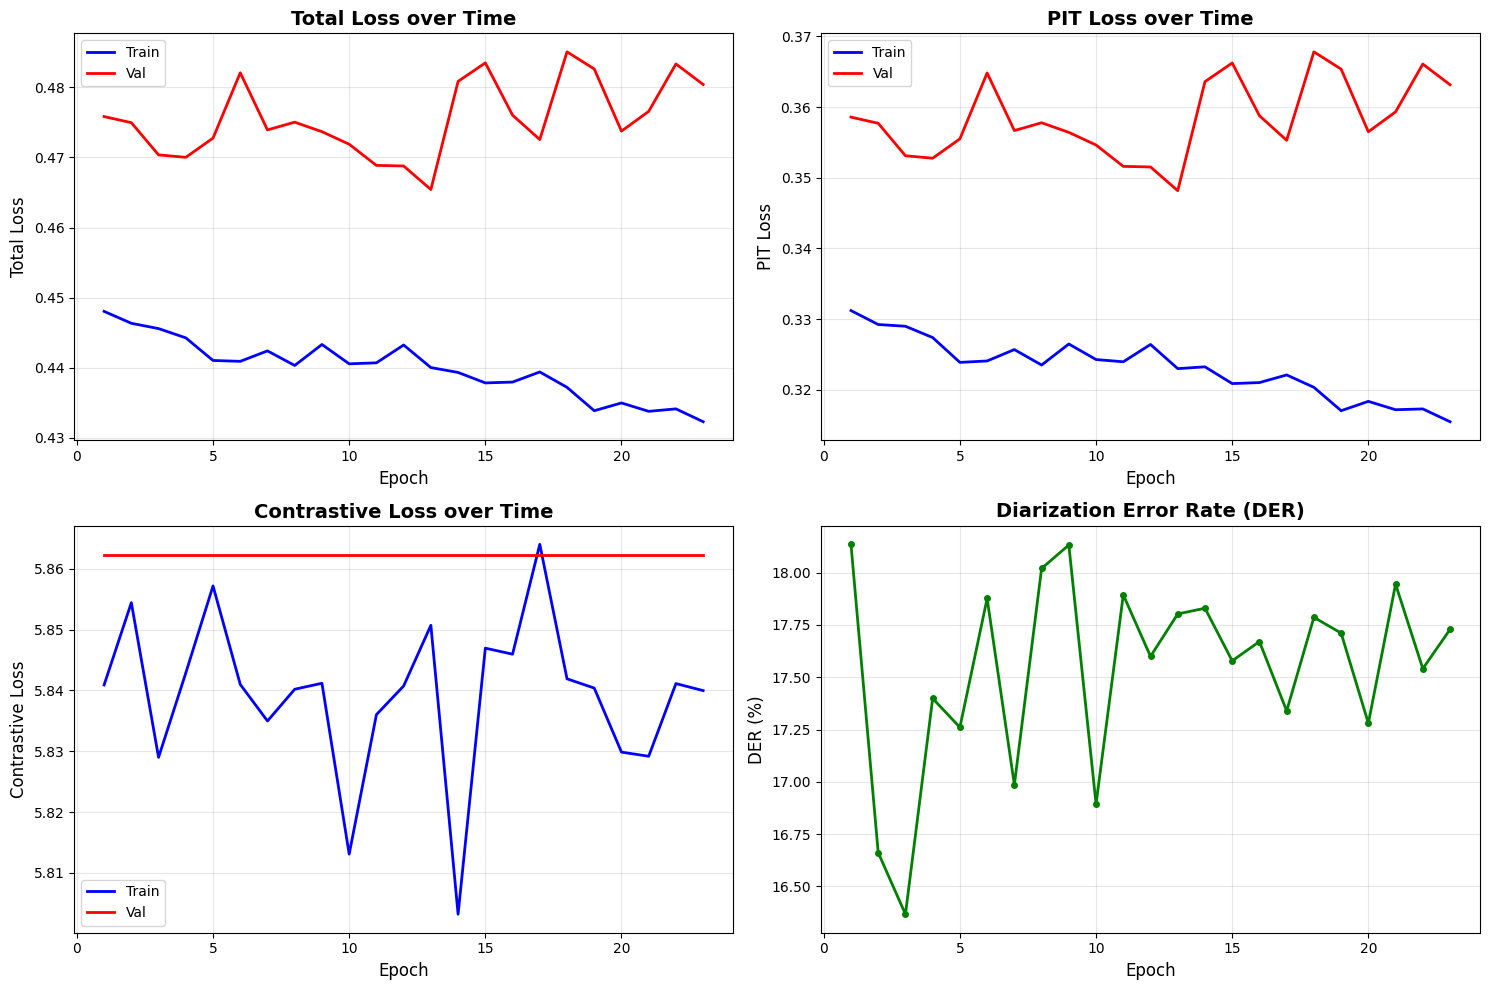

✓ Loss components saved: analysis/loss_components.png


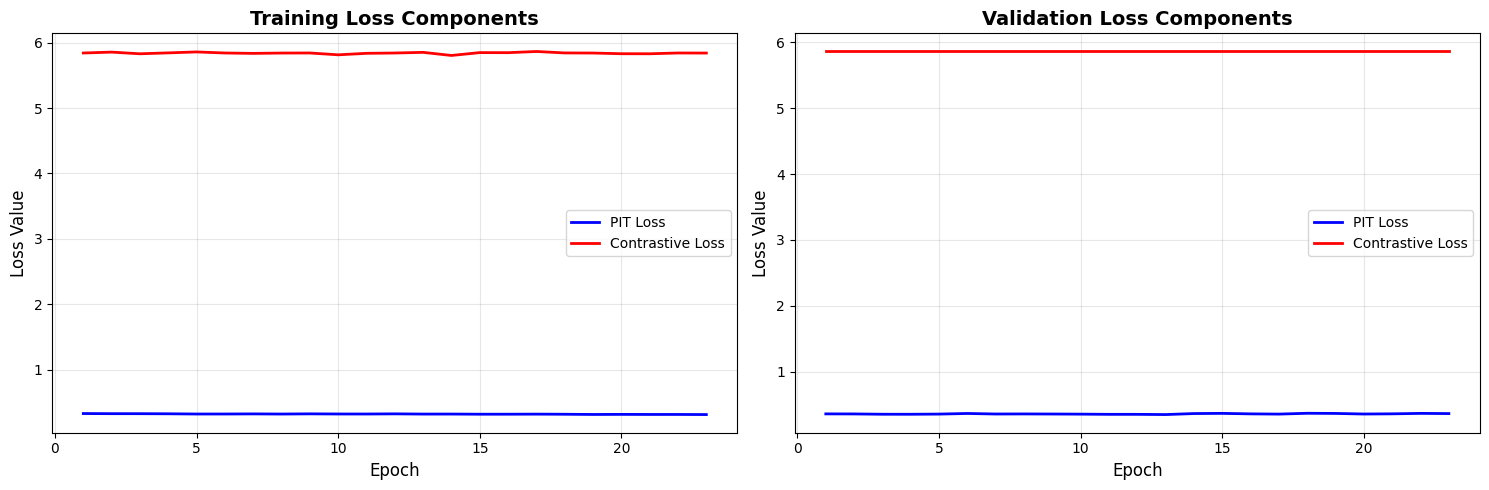

✓ Learning rate plot saved: analysis/learning_rate.png


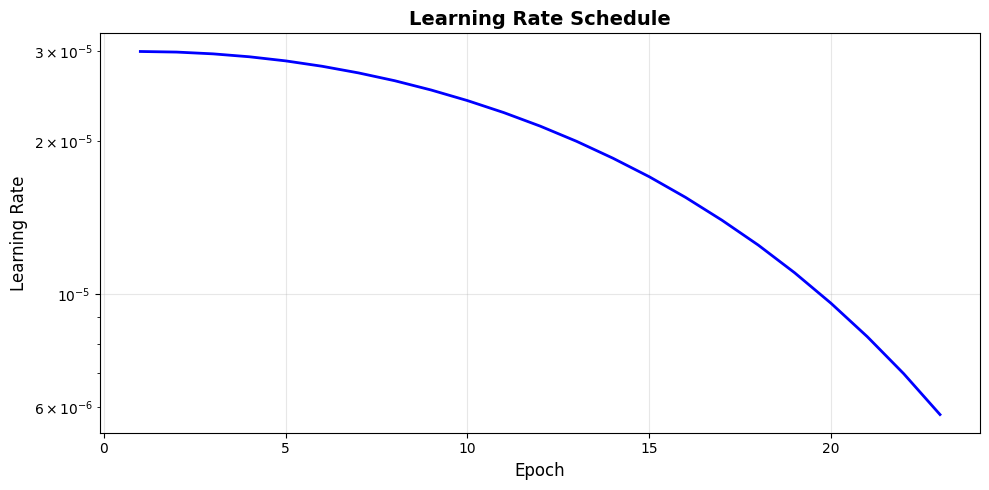

✓ Convergence analysis saved: analysis/convergence_analysis.png


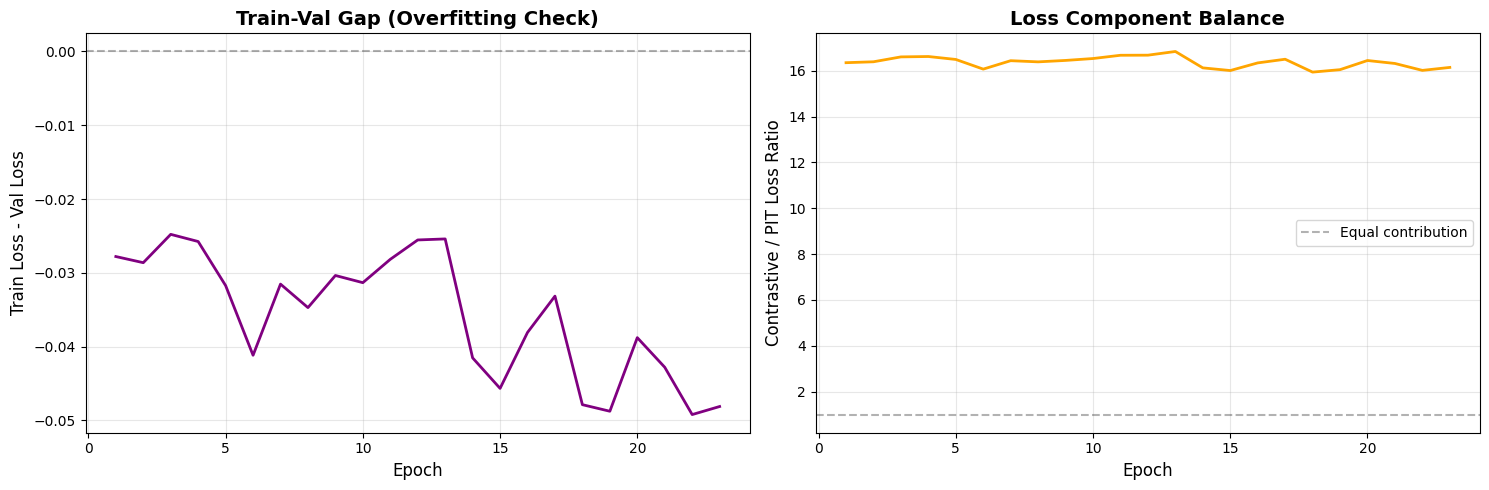

✓ Summary table saved: analysis/training_summary.csv

RECOMMENDATIONS

⚠️  Contrastive loss dominates (ratio: 16.14):
   → Consider: reducing contrastive_weight further

⚠️  Training has plateaued:
   Recent std dev: 0.004086
   → Consider: lowering learning rate or early stopping



In [9]:
"""
Analyze training logs from CSV
Generates plots and summary statistics
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def analyze_training_log(csv_path: str, save_dir: str = './analysis'):
    """
    Analyze training log and generate visualizations
    
    Args:
        csv_path: Path to training CSV log
        save_dir: Directory to save plots
    """
    # Load data
    df = pd.read_csv(csv_path)
    
    # Create output directory
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Split train/val
    train_df = df[df['phase'] == 'train'].copy()
    val_df = df[df['phase'] == 'val'].copy()
    
    # ============================================================================
    # 1. SUMMARY STATISTICS
    # ============================================================================
    print("="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    
    if len(val_df) > 0:
        best_epoch = val_df.loc[val_df['total_loss'].idxmin(), 'epoch']
        best_loss = val_df['total_loss'].min()
        best_der_epoch = val_df.loc[val_df['der'].idxmin(), 'epoch']
        best_der = val_df['der'].min()
        
        print(f"\n📊 Best Performance:")
        print(f"  Best Loss: {best_loss:.4f} at epoch {int(best_epoch)}")
        print(f"  Best DER:  {best_der:.2f}% at epoch {int(best_der_epoch)}")
        
        print(f"\n📈 Final Performance (Epoch {int(val_df['epoch'].max())}):")
        final_loss = val_df['total_loss'].iloc[-1]
        final_der = val_df['der'].iloc[-1]
        print(f"  Final Loss: {final_loss:.4f}")
        print(f"  Final DER:  {final_der:.2f}%")
        
        print(f"\n📉 Improvement:")
        initial_loss = val_df['total_loss'].iloc[0]
        initial_der = val_df['der'].iloc[0]
        loss_improvement = ((initial_loss - best_loss) / initial_loss) * 100
        der_improvement = ((initial_der - best_der) / initial_der) * 100
        print(f"  Loss: {loss_improvement:.1f}% improvement")
        print(f"  DER:  {der_improvement:.1f}% improvement")
    
    # ============================================================================
    # 2. LOSS CURVES
    # ============================================================================
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Total Loss
    ax = axes[0, 0]
    ax.plot(train_df['epoch'], train_df['total_loss'], 'b-', label='Train', linewidth=2)
    ax.plot(val_df['epoch'], val_df['total_loss'], 'r-', label='Val', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Total Loss', fontsize=12)
    ax.set_title('Total Loss over Time', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # PIT Loss
    ax = axes[0, 1]
    ax.plot(train_df['epoch'], train_df['pit_loss'], 'b-', label='Train', linewidth=2)
    ax.plot(val_df['epoch'], val_df['pit_loss'], 'r-', label='Val', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('PIT Loss', fontsize=12)
    ax.set_title('PIT Loss over Time', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Contrastive Loss
    ax = axes[1, 0]
    ax.plot(train_df['epoch'], train_df['contrast_loss'], 'b-', label='Train', linewidth=2)
    ax.plot(val_df['epoch'], val_df['contrast_loss'], 'r-', label='Val', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Contrastive Loss', fontsize=12)
    ax.set_title('Contrastive Loss over Time', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # DER
    ax = axes[1, 1]
    ax.plot(val_df['epoch'], val_df['der'], 'g-', linewidth=2, marker='o', markersize=4)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('DER (%)', fontsize=12)
    ax.set_title('Diarization Error Rate (DER)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_path = save_dir / 'training_curves.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Training curves saved: {plot_path}")
    plt.show()
    plt.close()
    
    # ============================================================================
    # 3. LOSS COMPONENTS COMPARISON
    # ============================================================================
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Train loss components
    ax = axes[0]
    ax.plot(train_df['epoch'], train_df['pit_loss'], 'b-', label='PIT Loss', linewidth=2)
    ax.plot(train_df['epoch'], train_df['contrast_loss'], 'r-', label='Contrastive Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss Value', fontsize=12)
    ax.set_title('Training Loss Components', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Val loss components
    ax = axes[1]
    ax.plot(val_df['epoch'], val_df['pit_loss'], 'b-', label='PIT Loss', linewidth=2)
    ax.plot(val_df['epoch'], val_df['contrast_loss'], 'r-', label='Contrastive Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss Value', fontsize=12)
    ax.set_title('Validation Loss Components', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_path = save_dir / 'loss_components.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Loss components saved: {plot_path}")
    plt.show()
    plt.close()
    
    # ============================================================================
    # 4. LEARNING RATE SCHEDULE
    # ============================================================================
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(train_df['epoch'], train_df['learning_rate'], 'b-', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Learning Rate', fontsize=12)
    ax.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plot_path = save_dir / 'learning_rate.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Learning rate plot saved: {plot_path}")
    plt.show()
    plt.close()
    
    # ============================================================================
    # 5. CONVERGENCE ANALYSIS
    # ============================================================================
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Train-Val Gap
    ax = axes[0]
    gap = train_df['total_loss'].values - val_df['total_loss'].values
    ax.plot(train_df['epoch'], gap, 'purple', linewidth=2)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Train Loss - Val Loss', fontsize=12)
    ax.set_title('Train-Val Gap (Overfitting Check)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Loss ratio
    ax = axes[1]
    ratio = val_df['contrast_loss'] / val_df['pit_loss']
    ax.plot(val_df['epoch'], ratio, 'orange', linewidth=2)
    ax.axhline(y=1, color='k', linestyle='--', alpha=0.3, label='Equal contribution')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Contrastive / PIT Loss Ratio', fontsize=12)
    ax.set_title('Loss Component Balance', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_path = save_dir / 'convergence_analysis.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Convergence analysis saved: {plot_path}")
    plt.show()
    plt.close()
    
    # ============================================================================
    # 6. SUMMARY TABLE
    # ============================================================================
    summary_path = save_dir / 'training_summary.csv'
    
    summary_data = []
    for epoch in val_df['epoch'].unique():
        epoch_val = val_df[val_df['epoch'] == epoch].iloc[0]
        epoch_train = train_df[train_df['epoch'] == epoch].iloc[0]
        
        summary_data.append({
            'epoch': int(epoch),
            'train_loss': epoch_train['total_loss'],
            'val_loss': epoch_val['total_loss'],
            'val_der': epoch_val['der'],
            'train_pit': epoch_train['pit_loss'],
            'val_pit': epoch_val['pit_loss'],
            'train_contrast': epoch_train['contrast_loss'],
            'val_contrast': epoch_val['contrast_loss'],
            'learning_rate': epoch_train['learning_rate']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(summary_path, index=False)
    print(f"✓ Summary table saved: {summary_path}")
    
    # ============================================================================
    # 7. RECOMMENDATIONS
    # ============================================================================
    print("\n" + "="*60)
    print("RECOMMENDATIONS")
    print("="*60)
    
    if len(val_df) > 5:
        # Check overfitting
        recent_gap = gap[-5:].mean()
        if recent_gap > 0.1:
            print("\n⚠️  High train-val gap detected:")
            print(f"   Average gap (last 5 epochs): {recent_gap:.4f}")
            print("   → Consider: stronger regularization, more dropout, or data augmentation")
        
        # Check loss balance
        final_ratio = ratio.iloc[-1]
        if final_ratio > 3:
            print(f"\n⚠️  Contrastive loss dominates (ratio: {final_ratio:.2f}):")
            print("   → Consider: reducing contrastive_weight further")
        elif final_ratio < 0.5:
            print(f"\n⚠️  PIT loss dominates (ratio: {final_ratio:.2f}):")
            print("   → Consider: increasing contrastive_weight")
        else:
            print(f"\n✓ Good loss balance (ratio: {final_ratio:.2f})")
        
        # Check convergence
        recent_improvement = val_df['total_loss'].iloc[-5:].std()
        if recent_improvement < 0.01:
            print("\n⚠️  Training has plateaued:")
            print(f"   Recent std dev: {recent_improvement:.6f}")
            print("   → Consider: lowering learning rate or early stopping")
    
    print("\n" + "="*60)


def compare_multiple_runs(csv_paths: list, labels: list, save_dir: str = './comparison'):
    """
    Compare multiple training runs
    
    Args:
        csv_paths: List of CSV file paths
        labels: List of labels for each run
        save_dir: Directory to save comparison plots
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    colors = ['b', 'r', 'g', 'orange', 'purple', 'brown']
    
    for i, (csv_path, label) in enumerate(zip(csv_paths, labels)):
        df = pd.read_csv(csv_path)
        val_df = df[df['phase'] == 'val']
        color = colors[i % len(colors)]
        
        # Total Loss
        axes[0, 0].plot(val_df['epoch'], val_df['total_loss'], 
                       color=color, label=label, linewidth=2, marker='o', markersize=3)
        
        # PIT Loss
        axes[0, 1].plot(val_df['epoch'], val_df['pit_loss'], 
                       color=color, label=label, linewidth=2, marker='o', markersize=3)
        
        # Contrastive Loss
        axes[1, 0].plot(val_df['epoch'], val_df['contrast_loss'], 
                       color=color, label=label, linewidth=2, marker='o', markersize=3)
        
        # DER
        axes[1, 1].plot(val_df['epoch'], val_df['der'], 
                       color=color, label=label, linewidth=2, marker='o', markersize=3)
    
    axes[0, 0].set_title('Total Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('PIT Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Contrastive Loss', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('DER', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('DER (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_path = save_dir / 'run_comparison.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Comparison plot saved: {plot_path}")
    plt.show()
    plt.close()


# ============================================================================
# USAGE
# ============================================================================

if __name__ == '__main__':
    # Single run analysis
    print("Analyzing training log...")
    analyze_training_log(
        csv_path='/kaggle/working/logs/training_log_20251020_133914.csv',  # Update with your own file
        save_dir='./analysis'
    )
    
    # Multiple runs comparison (optional)
    # compare_multiple_runs(
    #     csv_paths=[
    #         './logs/run1.csv',
    #         './logs/run2.csv',
    #         './logs/run3.csv'
    #     ],
    #     labels=[
    #         'Baseline (weight=0.05)',
    #         'Reduced weight (0.02)',
    #         'With augmentation'
    #     ],
    #     save_dir='./comparison'
    # )

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import Tuple, Dict, List, Optional
import random
from tqdm import tqdm
import math
from itertools import permutations
from scipy.optimize import linear_sum_assignment
import torch.nn.functional as F
from torch.utils.data import BatchSampler
def set_seed(seed=36):
    """Set random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def setup_device():
    """Setup device with comprehensive CUDA checking"""
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print(f"✅ CUDA is available!")
        print(f"🚀 Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        torch.cuda.empty_cache()
    else:
        device = torch.device("cpu")
        print("⚠️  CUDA not available, using CPU")
    return device
set_seed()
setup_device()

# For test set but doesnt exist

In [ ]:
def inference_simplified_phase3(model_path: str, audio_dir: str, output_dir: str,
                                chunk_size: float = 20.0, overlap: float = 3.0):
    """
    Run inference on test set with Simplified Phase 3 model
    
    Args:
        model_path: Path to trained model checkpoint
        audio_dir: Directory with test audio files
        output_dir: Where to save RTTM predictions
        chunk_size: Chunk size in seconds (match training: 20.0)
        overlap: Overlap in seconds (match training: 3.0)
    """
    from pathlib import Path
    import torch
    import torchaudio
    import numpy as np
    from tqdm import tqdm
    
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    print("="*60)
    print("Simplified Phase 3 Inference")
    print("="*60)
    print(f"Model: {model_path}")
    print(f"Audio dir: {audio_dir}")
    print(f"Output dir: {output_dir}")
    print(f"Chunk size: {chunk_size}s, Overlap: {overlap}s")
    print(f"Device: {device}")
    print("="*60)
    
    # Load model
    print("\n📦 Loading model...")
    checkpoint = torch.load(model_path, map_location=device)
    
    model = SimplifiedPhase3EEND(
        input_dim=83,
        d_model=128,
        encoder_layers=6,
        decoder_layers=2,
        n_heads=4,
        num_speakers=6,
        projection_dim=64
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print("✓ Model loaded successfully")
    
    # Audio processor
    audio_processor = AudioProcessor()
    
    # Get test files
    audio_dir = Path(audio_dir)
    audio_files = sorted(audio_dir.glob('*.wav'))
    
    if len(audio_files) == 0:
        print(f"❌ No audio files found in {audio_dir}")
        return
    
    print(f"\n🎤 Found {len(audio_files)} test files")
    print(f"Processing with chunk size {chunk_size}s, stride {chunk_size - overlap}s\n")
    
    # Process each file
    for audio_file in tqdm(audio_files, desc="Processing"):
        try:
            # Get audio info
            info = torchaudio.info(str(audio_file))
            duration = info.num_frames / info.sample_rate
            sample_rate = info.sample_rate
            
            # Process in chunks
            stride = chunk_size - overlap
            all_predictions = []
            
            chunk_start = 0.0
            while chunk_start < duration:
                chunk_end = min(chunk_start + chunk_size, duration)
                actual_chunk_duration = chunk_end - chunk_start
                
                # Skip very short chunks at the end
                if actual_chunk_duration < chunk_size * 0.3:
                    break
                
                # Load chunk
                start_frame = int(chunk_start * sample_rate)
                num_frames = int(actual_chunk_duration * sample_rate)
                
                waveform, sr = torchaudio.load(
                    str(audio_file),
                    frame_offset=start_frame,
                    num_frames=num_frames
                )
                
                # Resample if needed
                if sr != 16000:
                    resampler = torchaudio.transforms.Resample(sr, 16000)
                    waveform = resampler(waveform)
                
                # Pad to expected length if needed
                expected_samples = int(chunk_size * 16000)
                if waveform.shape[1] < expected_samples:
                    waveform = F.pad(waveform, (0, expected_samples - waveform.shape[1]))
                elif waveform.shape[1] > expected_samples:
                    waveform = waveform[:, :expected_samples]
                
                # Convert to mel spectrogram
                mel = audio_processor(waveform.squeeze(0))
                mel = mel.unsqueeze(0).to(device)
                
                # Inference
                with torch.no_grad():
                    activities = model.predict(mel)  # (1, frames, num_speakers)
                    activities = activities.cpu().squeeze(0).numpy()  # (frames, num_speakers)
                
                # Apply boundary smoothing (one of improvements!)
                activities = smooth_speaker_boundaries(activities, kernel_size=11)
                
                # Store predictions
                all_predictions.append({
                    'chunk_start': chunk_start,
                    'chunk_end': chunk_end,
                    'activities': activities,
                })
                
                # Move to next chunk
                chunk_start += stride
                if chunk_end >= duration:
                    break
            
            # Merge overlapping predictions
            merged_predictions = merge_overlapping_chunks(
                all_predictions, 
                overlap=overlap,
                chunk_size=chunk_size
            )
            
            # Create RTTM file
            rttm_path = output_dir / f"{audio_file.stem}.rttm"
            create_rttm_from_predictions(
                merged_predictions, 
                rttm_path, 
                file_id=audio_file.stem,
                frame_shift=0.01,
                threshold=0.5
            )
            
        except Exception as e:
            print(f"\n❌ Error processing {audio_file.name}: {e}")
            continue
    
    print(f"\n✓ Inference complete!")
    print(f"📁 Predictions saved to: {output_dir}")
    print("="*60)


def merge_overlapping_chunks(predictions: List[Dict], overlap: float, 
                            chunk_size: float) -> np.ndarray:
    """
    Merge predictions from overlapping chunks with weighted averaging
    
    Args:
        predictions: List of dicts with 'chunk_start', 'chunk_end', 'activities'
        overlap: Overlap duration in seconds
        chunk_size: Chunk duration in seconds
    
    Returns:
        merged: (total_frames, num_speakers) merged predictions
    """
    if len(predictions) == 0:
        return np.array([])
    
    if len(predictions) == 1:
        return predictions[0]['activities']
    
    # Calculate total duration
    last_chunk = predictions[-1]
    total_duration = last_chunk['chunk_end']
    frame_shift = 0.01  # 10ms frames
    total_frames = int(total_duration / frame_shift)
    num_speakers = predictions[0]['activities'].shape[1]
    
    # Initialize accumulator
    merged = np.zeros((total_frames, num_speakers))
    weights = np.zeros((total_frames, num_speakers))
    
    overlap_frames = int(overlap / frame_shift)
    
    for pred in predictions:
        chunk_start = pred['chunk_start']
        activities = pred['activities']
        chunk_frames = activities.shape[0]
        
        # Calculate frame indices in global timeline
        start_frame = int(chunk_start / frame_shift)
        end_frame = start_frame + chunk_frames
        end_frame = min(end_frame, total_frames)
        actual_frames = end_frame - start_frame
        
        # Create weights: higher in middle, lower at boundaries
        chunk_weights = np.ones((actual_frames, num_speakers))
        
        # Fade in at start (overlap region)
        if start_frame > 0:  # Not the first chunk
            fade_in_frames = min(overlap_frames, actual_frames)
            fade_in = np.linspace(0, 1, fade_in_frames).reshape(-1, 1)
            chunk_weights[:fade_in_frames] *= fade_in
        
        # Fade out at end (overlap region)
        if end_frame < total_frames:  # Not the last chunk
            fade_out_frames = min(overlap_frames, actual_frames)
            fade_out = np.linspace(1, 0, fade_out_frames).reshape(-1, 1)
            chunk_weights[-fade_out_frames:] *= fade_out
        
        # Accumulate
        merged[start_frame:end_frame] += activities[:actual_frames] * chunk_weights
        weights[start_frame:end_frame] += chunk_weights
    
    # Normalize by weights
    weights = np.maximum(weights, 1e-8)  # Avoid division by zero
    merged = merged / weights
    
    return merged


def create_rttm_from_predictions(activities: np.ndarray, output_path: str,
                                 file_id: str, frame_shift: float = 0.01, 
                                 threshold: float = 0.5, 
                                 min_duration: float = 0.3):
    """
    Convert frame-level predictions to RTTM format with post-processing
    
    Args:
        activities: (frames, num_speakers) - speaker activity probabilities
        output_path: Path to save RTTM file
        file_id: File identifier for RTTM
        frame_shift: Time per frame in seconds
        threshold: Activity threshold
        min_duration: Minimum segment duration in seconds
    """
    num_speakers = activities.shape[1]
    min_frames = int(min_duration / frame_shift)
    
    with open(output_path, 'w') as f:
        for spk_idx in range(num_speakers):
            spk_activity = activities[:, spk_idx] > threshold
            
            # Find continuous segments
            segments = []
            in_segment = False
            segment_start = 0
            
            for frame_idx, active in enumerate(spk_activity):
                if active and not in_segment:
                    # Start new segment
                    in_segment = True
                    segment_start = frame_idx
                elif not active and in_segment:
                    # End segment
                    in_segment = False
                    segment_length = frame_idx - segment_start
                    
                    # Only keep segments longer than minimum
                    if segment_length >= min_frames:
                        segments.append((segment_start, frame_idx))
                
            # Handle segment extending to end
            if in_segment:
                segment_length = len(spk_activity) - segment_start
                if segment_length >= min_frames:
                    segments.append((segment_start, len(spk_activity)))
            
            # Write segments to RTTM
            for start_frame, end_frame in segments:
                start_time = start_frame * frame_shift
                duration = (end_frame - start_frame) * frame_shift
                
                # RTTM format: SPEAKER <file> 1 <start> <duration> <NA> <NA> <speaker> <NA> <NA>
                f.write(f"SPEAKER {file_id} 1 {start_time:.3f} {duration:.3f} <NA> <NA> speaker_{spk_idx} <NA> <NA>\n")

# Run inference on VoxConverse test set
inference_simplified_phase3(
    model_path='/kaggle/input/3/pytorch/default/1/simple_phase3_best.pth',
    audio_dir='/kaggle/input/voxconverse-dataset/voxconverse_test_wav/voxconverse_test_wav',
    output_dir='./voxconverse_test_predictions',
    chunk_size=20.0,  # Match training
    overlap=3.0       # Match training
)

print("\n🎉 Inference complete!")
print("📁 Predictions saved to: ./voxconverse_test_predictions")
print("\nNext steps:")
print("1. If we find test labels files later, evaluate with pyannote.metrics right below")
print("2. Compare predictions visually")
print("3. Include in paper results section (I'll do this lol)")

In [ ]:
!pip install -q pyannote.metrics pyannote.core


In [ ]:

from pyannote.core import Annotation, Segment
from pyannote.metrics.diarization import DiarizationErrorRate


def evaluate_with_pyannote(pred_dir: str, ref_dir: str):
    """
    Evaluate predictions with pyannote.metrics
    
    Args:
        pred_dir: Directory with predicted RTTM files
        ref_dir: Directory with reference RTTM files
    """
    from pyannote.core import Annotation, Segment
    from pyannote.metrics.diarization import DiarizationErrorRate
    from pathlib import Path
    
    pred_dir = Path(pred_dir)
    ref_dir = Path(ref_dir)
    
    # Initialize metric with collar tolerance
    metric = DiarizationErrorRate(collar=0.25, skip_overlap=False)
    
    # Get all prediction files
    pred_files = sorted(pred_dir.glob('*.rttm'))
    
    print(f"\n📊 Evaluating {len(pred_files)} files...")
    
    for pred_file in tqdm(pred_files):
        ref_file = ref_dir / pred_file.name
        
        if not ref_file.exists():
            print(f"⚠️  No reference for {pred_file.name}")
            continue
        
        # Load predictions
        pred_ann = load_rttm(pred_file)
        ref_ann = load_rttm(ref_file)
        
        # Compute metric
        metric(ref_ann, pred_ann)
    
    # Print results
    print("\n" + "="*60)
    print("Diarization Error Rate (DER)")
    print("="*60)
    print(f"DER: {abs(metric):.2f}%")
    print(f"  False Alarm: {metric['false alarm']:.2f}%")
    print(f"  Missed Detection: {metric['missed detection']:.2f}%")
    print(f"  Confusion: {metric['confusion']:.2f}%")
    print("="*60)

def load_rttm(rttm_path: str) -> Annotation:
    """Load RTTM file into pyannote Annotation"""
    from pyannote.core import Annotation, Segment
    
    annotation = Annotation()
    
    with open(rttm_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 8 or parts[0] != 'SPEAKER':
                continue
            
            start = float(parts[3])
            duration = float(parts[4])
            speaker = parts[7]
            
            annotation[Segment(start, start + duration)] = speaker
    
    return annotation

In [ ]:
!pip install tqdm

In [ ]:
# Cell: Analyze VoxConverse Speaker Distribution
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def analyze_voxconverse_speakers(rttm_dir: str):
    """Analyze speaker distribution in VoxConverse"""
    rttm_dir = Path(rttm_dir)
    rttm_files = sorted(rttm_dir.glob('*.rttm'))
    
    total_speakers = []
    max_simultaneous = []
    
    for rttm_file in tqdm(rttm_files, desc="Analyzing RTTM files"):
        # Parse RTTM
        speaker_segments = {}
        with open(rttm_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 8 or parts[0] != 'SPEAKER':
                    continue
                
                start = float(parts[3])
                dur = float(parts[4])
                speaker = parts[7]
                
                if speaker not in speaker_segments:
                    speaker_segments[speaker] = []
                
                speaker_segments[speaker].append({
                    'start': start,
                    'end': start + dur
                })
        
        # Total unique speakers
        total_speakers.append(len(speaker_segments))
        
        # Calculate max simultaneous speakers
        events = []
        for spk, segments in speaker_segments.items():
            for seg in segments:
                events.append((seg['start'], 1))
                events.append((seg['end'], -1))
        
        events.sort()
        
        current = 0
        max_sim = 0
        for time, delta in events:
            current += delta
            max_sim = max(max_sim, current)
        
        max_simultaneous.append(max_sim)
    
    # Print statistics
    print("\n" + "="*60)
    print("VoxConverse Speaker Statistics")
    print("="*60)
    print(f"Total conversations: {len(rttm_files)}")
    print("\nTotal unique speakers per conversation:")
    print(f"  Mean: {np.mean(total_speakers):.1f}")
    print(f"  Median: {np.median(total_speakers):.0f}")
    print(f"  Max: {np.max(total_speakers)}")
    print(f"  95th percentile: {np.percentile(total_speakers, 95):.0f}")
    print("\nMax simultaneous speakers:")
    print(f"  Mean: {np.mean(max_simultaneous):.1f}")
    print(f"  Median: {np.median(max_simultaneous):.0f}")
    print(f"  Max: {np.max(max_simultaneous)}")
    print(f"  95th percentile: {np.percentile(max_simultaneous, 95):.0f}")
    print("\n✅ Recommendation:")
    percentile_95 = np.percentile(max_simultaneous, 95)
    if percentile_95 <= 6:
        print(f"   Use num_speakers=6 (covers 95% of cases)")
    elif percentile_95 <= 8:
        print(f"   Use num_speakers=8 (covers 95% of cases)")
    else:
        print(f"   Use num_speakers=10 (for safety)")
    print("="*60)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(total_speakers, bins=range(1, max(total_speakers)+2), edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Total Unique Speakers in Conversation', fontsize=12)
    axes[0].set_ylabel('Number of Conversations', fontsize=12)
    axes[0].set_title('Distribution: Total Speakers', fontsize=14, fontweight='bold')
    axes[0].axvline(6, color='red', linestyle='--', linewidth=2, label='Typical model capacity: 6')
    axes[0].grid(alpha=0.3)
    axes[0].legend()
    
    axes[1].hist(max_simultaneous, bins=range(1, max(max_simultaneous)+2), edgecolor='black', alpha=0.7, color='orange')
    axes[1].set_xlabel('Max Simultaneous Speakers', fontsize=12)
    axes[1].set_ylabel('Number of Conversations', fontsize=12)
    axes[1].set_title('Distribution: Max Simultaneous Speakers', fontsize=14, fontweight='bold')
    axes[1].axvline(6, color='red', linestyle='--', linewidth=2, label='Typical model capacity: 6')
    axes[1].grid(alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('voxconverse_speaker_stats.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Visualization saved to voxconverse_speaker_stats.png\n")
    
    return {
        'total_speakers': total_speakers,
        'max_simultaneous': max_simultaneous
    }

# Run analysis
stats = analyze_voxconverse_speakers('/kaggle/input/voxconverse-dataset/labels/dev')

# Print some examples
print("\n📊 Sample conversations:")
print(f"Conversations with >6 total speakers: {sum(1 for x in stats['total_speakers'] if x > 6)}")
print(f"Conversations with >6 simultaneous speakers: {sum(1 for x in stats['max_simultaneous'] if x > 6)}")